In [ ]:
%pip install gymnasium
%pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from gymnasium import Env
from gymnasium.spaces import Discrete
import time
import optuna

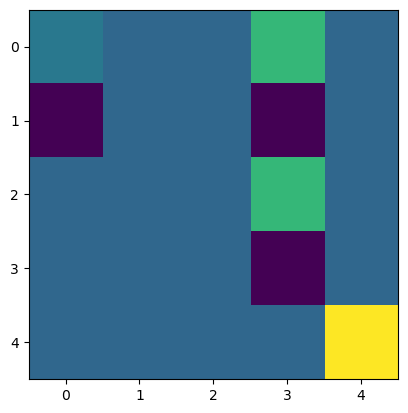

TimeStep: 1, State: [0 0], Action: 0, Reward: -0.5, Cumulative Reward: -0.5


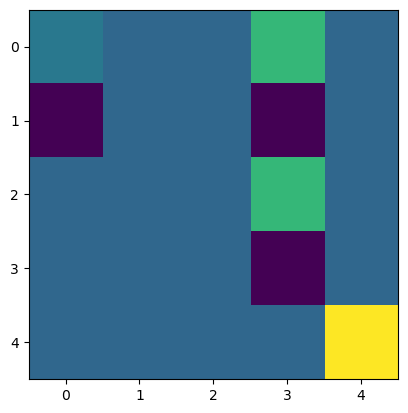

TimeStep: 2, State: [1 0], Action: 2, Reward: -20, Cumulative Reward: -20.5


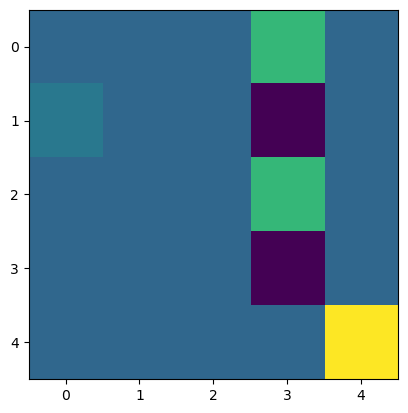

TimeStep: 3, State: [2 0], Action: 2, Reward: -0.5, Cumulative Reward: -21.0


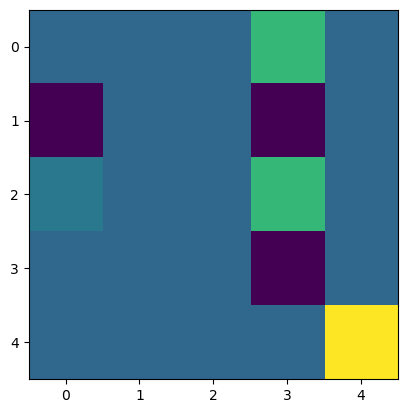

TimeStep: 4, State: [2 0], Action: 3, Reward: -0.5, Cumulative Reward: -21.5


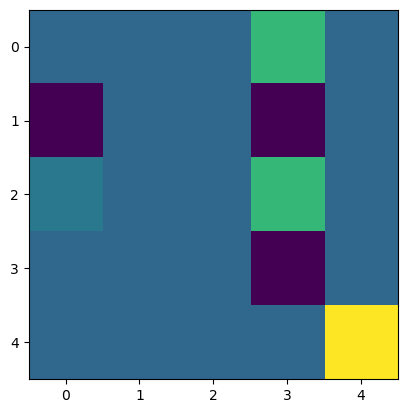

TimeStep: 5, State: [2 0], Action: 3, Reward: -0.5, Cumulative Reward: -22.0


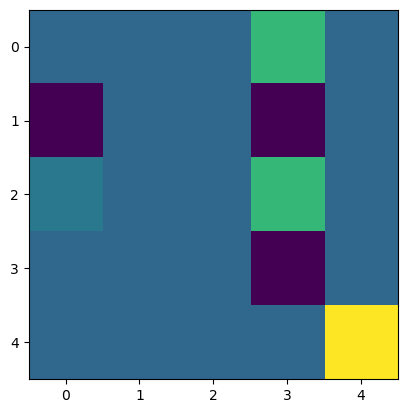

TimeStep: 6, State: [3 0], Action: 2, Reward: -0.5, Cumulative Reward: -22.5


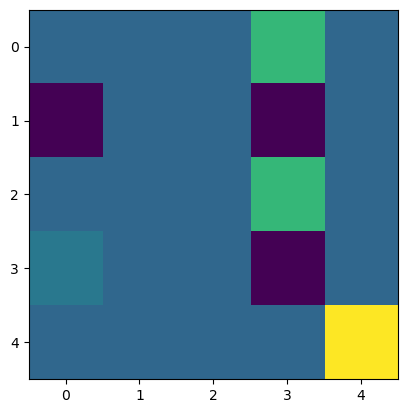

TimeStep: 7, State: [3 1], Action: 1, Reward: -0.5, Cumulative Reward: -23.0


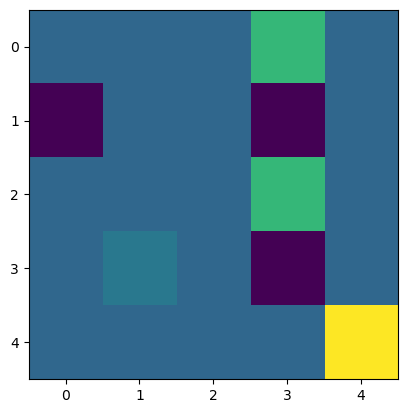

TimeStep: 8, State: [3 2], Action: 1, Reward: -0.5, Cumulative Reward: -23.5


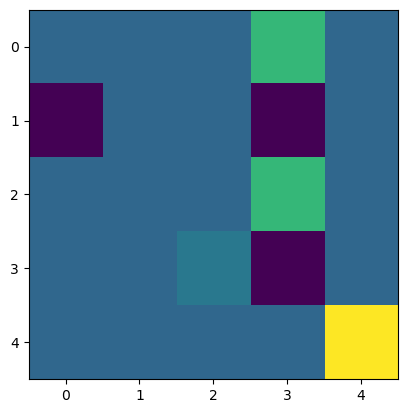

TimeStep: 9, State: [2 2], Action: 0, Reward: -0.5, Cumulative Reward: -24.0


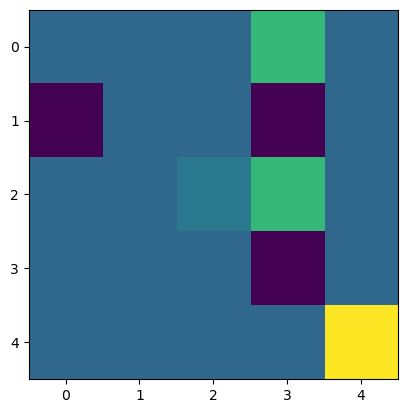

TimeStep: 10, State: [3 2], Action: 2, Reward: -0.5, Cumulative Reward: -24.5


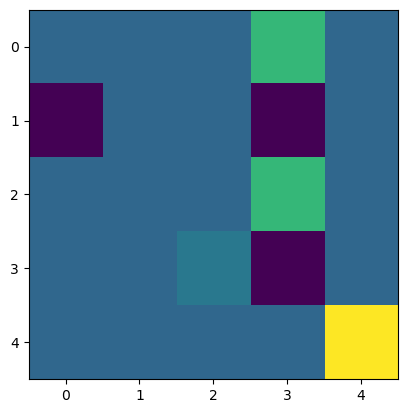

TimeStep: 11, State: [3 1], Action: 3, Reward: -0.5, Cumulative Reward: -25.0


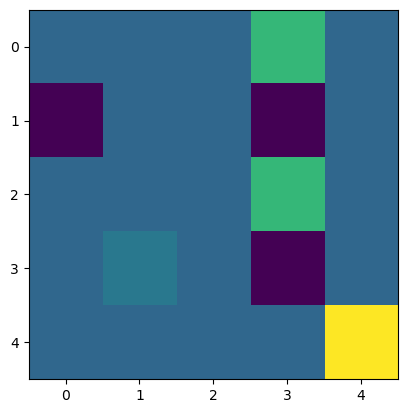

TimeStep: 12, State: [4 1], Action: 2, Reward: -0.5, Cumulative Reward: -25.5


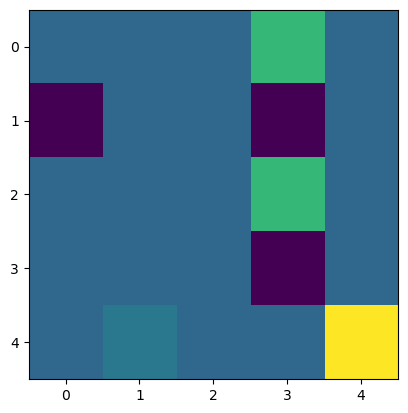

TimeStep: 13, State: [3 1], Action: 0, Reward: -0.5, Cumulative Reward: -26.0


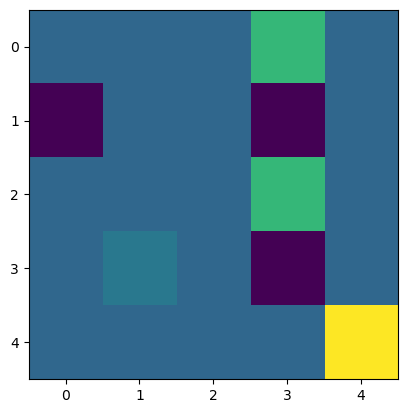

TimeStep: 14, State: [3 0], Action: 3, Reward: -0.5, Cumulative Reward: -26.5


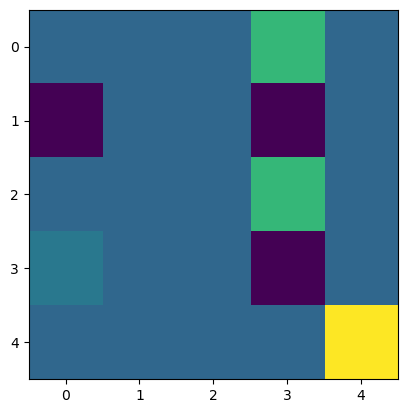

TimeStep: 15, State: [3 0], Action: 3, Reward: -0.5, Cumulative Reward: -27.0


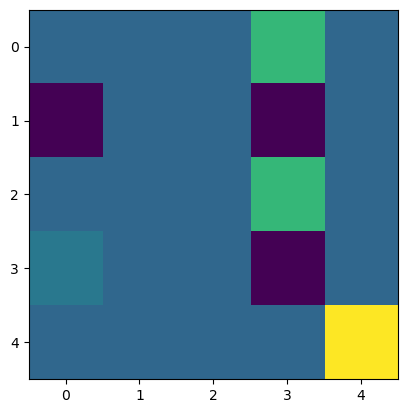

TimeStep: 16, State: [4 0], Action: 2, Reward: -0.5, Cumulative Reward: -27.5


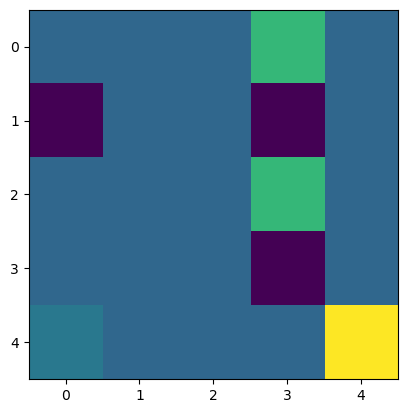

TimeStep: 17, State: [4 1], Action: 1, Reward: -0.5, Cumulative Reward: -28.0


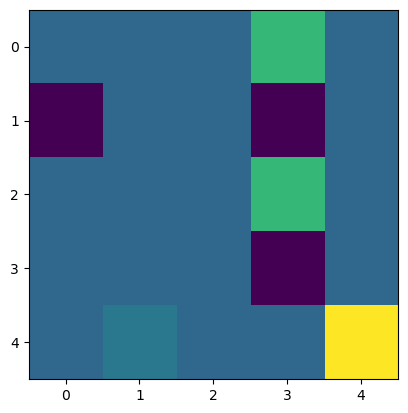

TimeStep: 18, State: [4 1], Action: 2, Reward: -0.5, Cumulative Reward: -28.5


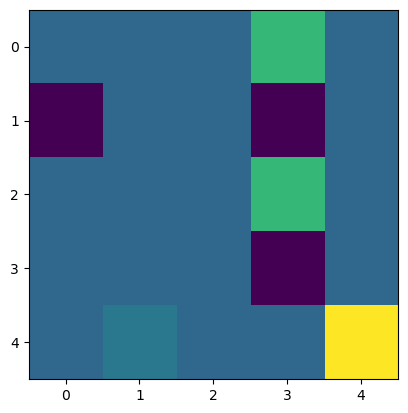

TimeStep: 19, State: [4 2], Action: 1, Reward: -0.5, Cumulative Reward: -29.0


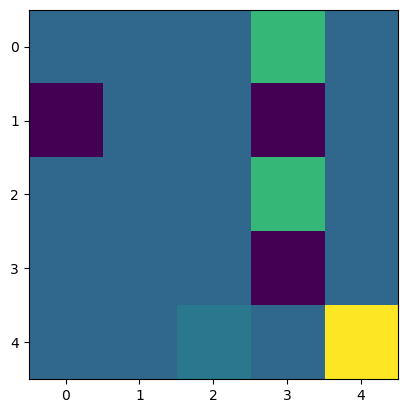

TimeStep: 20, State: [4 1], Action: 3, Reward: -0.5, Cumulative Reward: -29.5


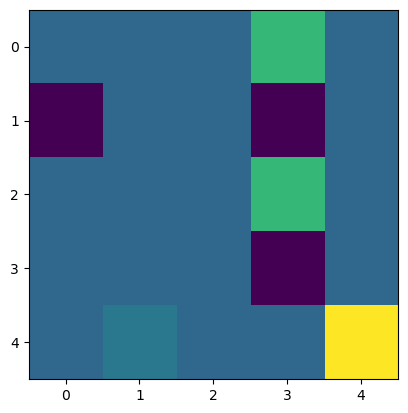

TimeStep: 21, State: [4 0], Action: 3, Reward: -0.5, Cumulative Reward: -30.0


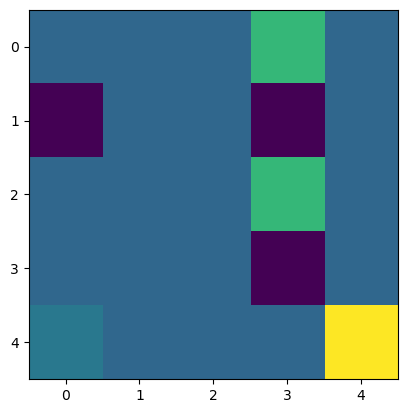

TimeStep: 22, State: [4 0], Action: 3, Reward: -0.5, Cumulative Reward: -30.5


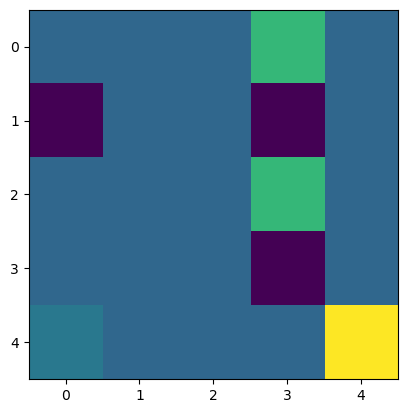

TimeStep: 23, State: [4 1], Action: 1, Reward: -0.5, Cumulative Reward: -31.0


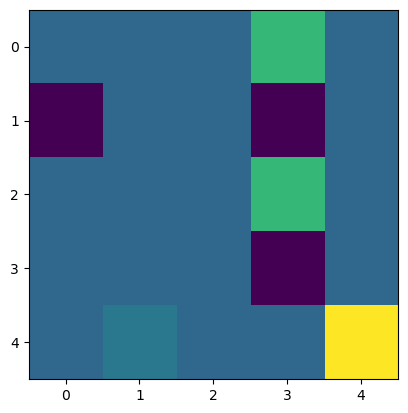

TimeStep: 24, State: [4 2], Action: 1, Reward: -0.5, Cumulative Reward: -31.5


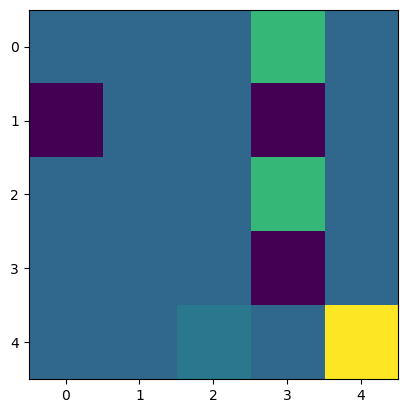

TimeStep: 25, State: [4 3], Action: 1, Reward: -0.5, Cumulative Reward: -32.0


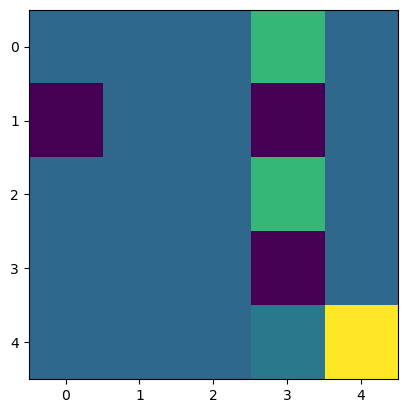

TimeStep: 26, State: [4 3], Action: 2, Reward: -0.5, Cumulative Reward: -32.5


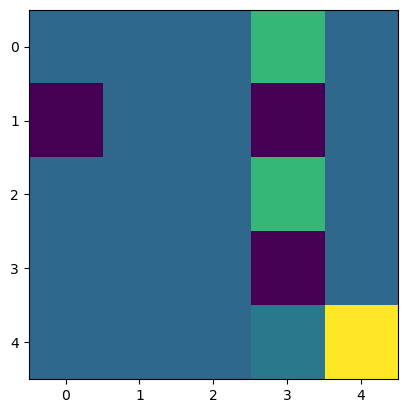

TimeStep: 27, State: [4 4], Action: 1, Reward: 100, Cumulative Reward: 67.5


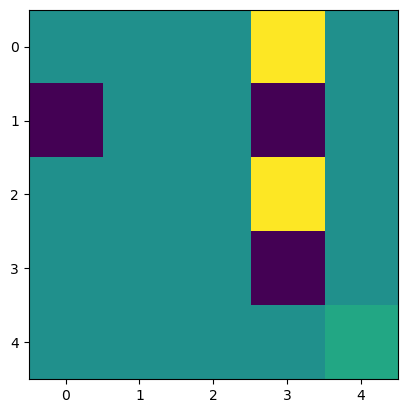

Final Cumulative Reward: 67.5


In [ ]:
class TreasureHuntEnv(Env):
    def __init__(self):
        self.action_space = Discrete(4)  
        self.observation_space = Discrete(25)
        self.max_timesteps = 100
        self.cumulative_reward = 0
        self.grid_size = (5,5)
        self.agent_pos = [0, 0]
        self.goal_pos = [4, 4]
        self.timestep = 0
        self.state = np.zeros(self.grid_size)
        self.treasures = [(0,3),(2, 3)] 
        self.traps = [(1, 0), (1, 3),(3,3)] 
        self.loadRewards()
        
        

    def reset(self):
        self.loadRewards()
        self.agent_pos = [0, 0]  
        self.timestep = 0
        self.cumulative_reward = 0
        self.state[tuple(self.agent_pos)] = 1
        observation = self.state.flatten()
        return self.agent_pos, observation

    def step(self, action):    
        if action == 0:  # Up
            self.agent_pos[0] -= 1
        elif action == 1:  # Right
            self.agent_pos[1] += 1
        elif action == 2:  # Down
            self.agent_pos[0] += 1
        elif action == 3:  # Left
            self.agent_pos[1] -= 1

        self.agent_pos = np.clip(self.agent_pos, 0, self.grid_size[0] - 1)
        self.timestep += 1

        reward=self.addRewards()
        self.cumulative_reward += reward

        terminated = tuple(self.agent_pos) == tuple(self.goal_pos)
        truncated = self.timestep >= self.max_timesteps

        self.loadRewards()
        self.state[tuple(self.agent_pos)] = 1
        observation = self.state.flatten()

        info = {}
        return self.agent_pos, reward, terminated, truncated,observation,info

    def render(self): 
        plt.imshow(self.state)
        plt.show()
    
    def loadRewards(self):
        self.state = np.zeros(self.grid_size)
        for t in self.treasures:
            self.state[t] = 5
        for tr in self.traps:
            self.state[tr] = -5 
        self.state[tuple(self.goal_pos)] = 10

    def addRewards(self):
        if tuple(self.agent_pos) == tuple(self.goal_pos):
            reward = 100 
        elif tuple(self.agent_pos) in self.treasures:
            reward = 20 
            self.treasures.remove(tuple(self.agent_pos)) # remove the treasure once collected
        elif tuple(self.agent_pos) in self.traps:
            reward = -20
        else:
            reward = -0.5
        return reward


env = TreasureHuntEnv()
state = env.reset()
env.render()

terminated, truncated, i = False, False, 0
while not terminated and not truncated:
    action = env.action_space.sample()
    state, reward, terminated, truncated, observation, info = env.step(action)
    print(f"TimeStep: {i+1}, State: {state}, Action: {action}, Reward: {reward}, Cumulative Reward: {env.cumulative_reward}")
    env.render()
    i += 1

print(f"Final Cumulative Reward: {env.cumulative_reward}")


In [3]:
def SARSA(env, episodes, alpha, gamma, epsilon, epsilon_decay, minimum_epsilon, maximum_timestep):
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    rewards_per_episode = []
    epsilon_value = []

    for episode in range(episodes):
        state, _ = env.reset()
        current_state = np.ravel_multi_index(state, env.grid_size)  
        current_action = np.random.choice(env.action_space.n) if np.random.rand() < epsilon else np.argmax(Q[current_state])
        reward_sum = 0

        for t in range(maximum_timestep):
            next_state, reward, goal_reached, cutoff, _, _ = env.step(current_action)
            reward_sum += reward
            next_state_index = np.ravel_multi_index(next_state, env.grid_size)
            next_action = (np.random.choice(env.action_space.n)
                if np.random.rand() < epsilon
                else np.argmax(Q[next_state_index])
            )

            Q[current_state, current_action] += alpha * (reward + gamma * Q[next_state_index, next_action] - Q[current_state, current_action])
            current_state, current_action = next_state_index, next_action

            if goal_reached or cutoff:
                break

        epsilon = max(epsilon * epsilon_decay, minimum_epsilon)

        rewards_per_episode.append(reward_sum)
        epsilon_value.append(epsilon)

    return Q, rewards_per_episode, epsilon_value



In [4]:
episodes = 500
alpha = 0.1  
gamma = 0.9  
epsilon = 1.0  
epsilon_decay = 0.99
minimum_epsilon = 0.1
maximum_timestep = 100

initial_Q = np.zeros((env.observation_space.n, env.action_space.n))  
trained_Q, rewards, epsilon_value = SARSA(env, episodes, alpha, gamma, epsilon, epsilon_decay, minimum_epsilon, maximum_timestep)
print("Initial Q-table:")
print(initial_Q)
print("\nTrained Q-table:")
print(trained_Q)


Initial Q-table:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Trained Q-table:
[[  8.71679291  29.85743238 -24.28952558  15.15018178]
 [ 11.05923381  39.11519881   2.6285768    8.85840871]
 [ 27.92668883  47.38960326   8.89418071   9.28203833]
 [ 28.75427739  54.67673887 -11.23649052  22.51127447]
 [ 39.84926815  30.74814384  63.4087129   23.13751235]
 [ -6.16584316   2.54699266  -7.23535406 -30.0581881 ]
 [ -2.58778717  -6.04985265  20.73152759 -28.58202897]
 [ -2.3378986  -19.18816188  29.63074544  -6.95903631]
 [ -1.58892596  -2.07604742  51.53619563  -3.76560036]
 [ 27.62063754  46.74361549  69.45581976   1.60845074]
 [-24.54247517  -2.02594585  -1.6084562

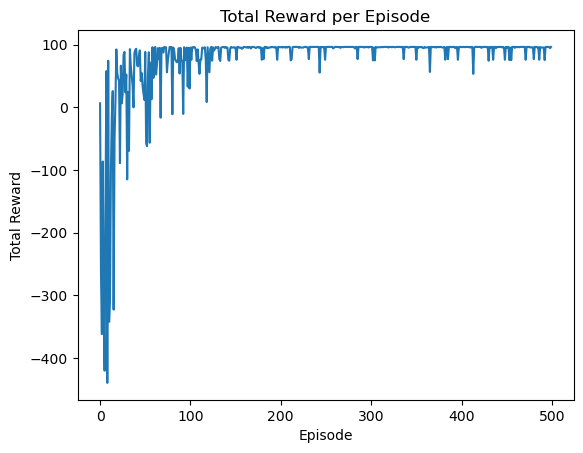

In [5]:
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward per Episode")
plt.show()


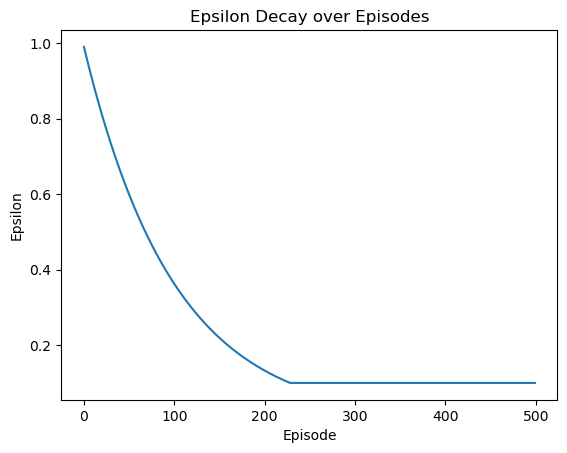

In [6]:
plt.plot(epsilon_value)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Epsilon Decay over Episodes")
plt.show()


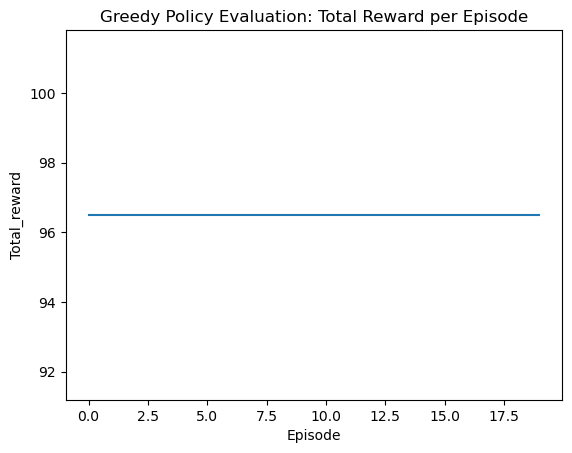

In [7]:
def evaluate_policy(env, Q, episodes=20):
    rewards = []
    for _ in range(episodes):
        state, _ = env.reset()
        current_state = np.ravel_multi_index(state, env.grid_size)
        reward_sum = 0
        done = False

        while not done:
            current_action = np.argmax(Q[current_state])
            next_state, reward, goal_reached, cutoff, _, _ = env.step(current_action)
            reward_sum += reward
            current_state = np.ravel_multi_index(next_state, env.grid_size)

            if goal_reached or cutoff:
                break

        rewards.append(reward_sum)

    return rewards

greedy_rewards = evaluate_policy(env, trained_Q)
plt.plot(greedy_rewards)
plt.xlabel("Episode")
plt.ylabel("Total_reward")
plt.title("Greedy Policy Evaluation: Total Reward per Episode")
plt.show()


In [ ]:
def objective(trial):
    gamma = trial.suggest_categorical("gamma", [0.7, 0.89, 0.99])
    epsilon_decay = trial.suggest_categorical("epsilon_decay", [0.93, 0.975, 0.999])
    _, rewards, _ = SARSA(env, episodes, alpha, gamma, epsilon, epsilon_decay, minimum_epsilon, maximum_timestep)
    return np.mean(rewards[-200:])  

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)
print("Best hyperparameters:", study.best_params)



[I 2024-12-05 18:52:17,068] A new study created in memory with name: no-name-bd520394-cbbf-4299-a6ae-c3f20bda08d4
[I 2024-12-05 18:52:17,150] Trial 0 finished with value: 94.3625 and parameters: {'gamma': 0.89, 'epsilon_decay': 0.93}. Best is trial 0 with value: 94.3625.
[I 2024-12-05 18:52:17,253] Trial 1 finished with value: 94.055 and parameters: {'gamma': 0.7, 'epsilon_decay': 0.975}. Best is trial 0 with value: 94.3625.
[I 2024-12-05 18:52:17,593] Trial 2 finished with value: 55.6125 and parameters: {'gamma': 0.89, 'epsilon_decay': 0.999}. Best is trial 0 with value: 94.3625.
[I 2024-12-05 18:52:17,958] Trial 3 finished with value: 52.3875 and parameters: {'gamma': 0.7, 'epsilon_decay': 0.999}. Best is trial 0 with value: 94.3625.
[I 2024-12-05 18:52:18,321] Trial 4 finished with value: 43.245 and parameters: {'gamma': 0.7, 'epsilon_decay': 0.999}. Best is trial 0 with value: 94.3625.
[I 2024-12-05 18:52:18,675] Trial 5 finished with value: 51.025 and parameters: {'gamma': 0.99, '

Best hyperparameters: {'gamma': 0.99, 'epsilon_decay': 0.93}


In [9]:
best_params = study.best_params
final_Q_table, final_rewards, final_epsilon_values = SARSA(
    env, episodes, alpha, best_params["gamma"], epsilon, best_params["epsilon_decay"], minimum_epsilon, maximum_timestep
)


In [10]:
def re_evaluate_greedy_policy(env, Q, episodes=10, max_timesteps=maximum_timestep):
    rewards = []
    for episode in range(episodes):
        state, _ = env.reset()
        current_state = np.ravel_multi_index(state, env.grid_size)
        total_reward = 0

        for t in range(max_timesteps):
            current_action = np.argmax(Q[current_state])
            next_state, reward, goal_reached, cutoff, _, _ = env.step(current_action)
            total_reward += reward
            current_state = np.ravel_multi_index(next_state, env.grid_size)
            if goal_reached or cutoff:
                break

        rewards.append(total_reward)
    return rewards

re_evaluated_rewards = re_evaluate_greedy_policy(env, final_Q_table, episodes=10)
print(f"Average Reward (Greedy Policy): {np.mean(re_evaluated_rewards)}")

Average Reward (Greedy Policy): 96.5


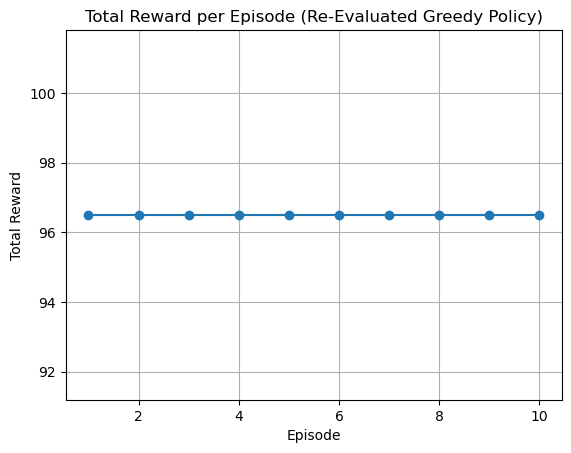

In [11]:
plt.plot(range(1, len(re_evaluated_rewards) + 1), re_evaluated_rewards, marker='o')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward per Episode (Re-Evaluated Greedy Policy)")
plt.grid()
plt.show()

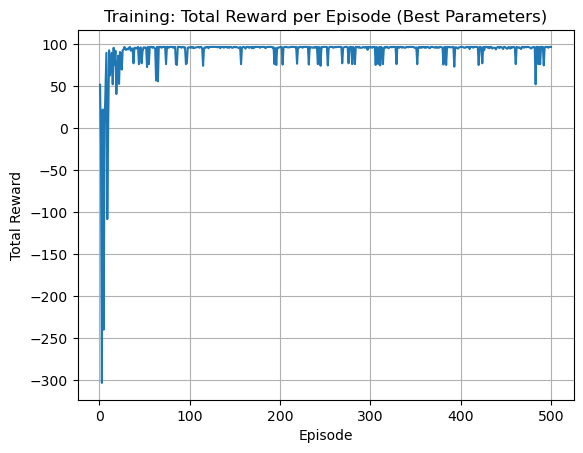

In [12]:
plt.plot(range(1, len(final_rewards) + 1), final_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training: Total Reward per Episode (Best Parameters)")
plt.grid()
plt.show()

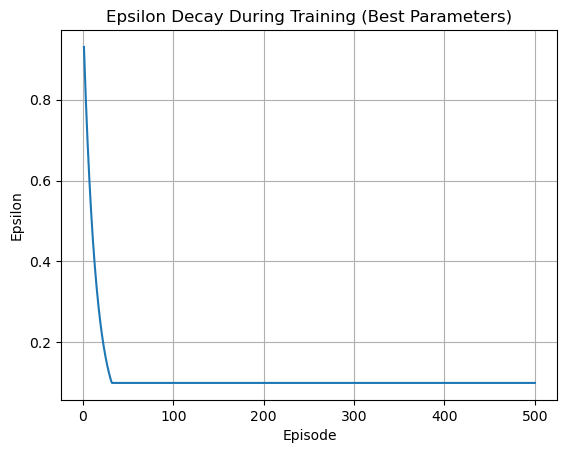

In [13]:
plt.plot(range(1, len(final_epsilon_values) + 1), final_epsilon_values)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Epsilon Decay During Training (Best Parameters)")
plt.grid()
plt.show()

In [14]:
def n_step_double_q_learning(env, episodes, alpha, gamma, epsilon, epsilon_decay, minimum_epsilon, maximum_timestep, n):
    Q_A = np.zeros((env.observation_space.n, env.action_space.n))
    Q_B = np.zeros((env.observation_space.n, env.action_space.n))
    rewards_per_episode = []
    epsilon_value = []

    for episode in range(episodes):
        state, _ = env.reset()
        current_state = np.ravel_multi_index(state, env.grid_size)
        current_action = np.random.choice(env.action_space.n) if np.random.rand() < epsilon else np.argmax(
            Q_A[current_state] + Q_B[current_state]
        )

        episode_buffer = []
        reward_sum = 0

        for t in range(maximum_timestep):
            next_state, reward, goal_reached, cutoff, _, _ = env.step(current_action)
            next_state_index = np.ravel_multi_index(next_state, env.grid_size)
            reward_sum += reward

            next_action = (
                np.random.choice(env.action_space.n)
                if np.random.rand() < epsilon
                else np.argmax(Q_A[next_state_index] + Q_B[next_state_index])
            )

            episode_buffer.append((current_state, current_action, reward))

            if len(episode_buffer) >= n or goal_reached or cutoff:
                G = sum([gamma ** i * episode_buffer[i][2] for i in range(len(episode_buffer))])
                if not (goal_reached or cutoff):
                    G += gamma ** n * (Q_A[next_state_index, next_action] + Q_B[next_state_index, next_action]) / 2

                update_state, update_action, _ = episode_buffer.pop(0)

                if np.random.rand() < 0.5:
                    Q_A[update_state, update_action] += alpha * (G - Q_A[update_state, update_action])
                else:
                    Q_B[update_state, update_action] += alpha * (G - Q_B[update_state, update_action])

            current_state, current_action = next_state_index, next_action

            if goal_reached or cutoff:
                break

        epsilon = max(epsilon * epsilon_decay, minimum_epsilon)

        rewards_per_episode.append(reward_sum)
        epsilon_value.append(epsilon)

    return Q_A, Q_B, rewards_per_episode, epsilon_value


In [15]:
episodes = 500
episodes = 500
alpha = 0.1  
gamma = 0.9  
epsilon = 1.0  
epsilon_decay = 0.99
minimum_epsilon = 0.1
maximum_timestep = 100

In [16]:

def objective(trial):
    gamma = trial.suggest_categorical("gamma", [0.7, 0.89, 0.99])
    epsilon_decay = trial.suggest_categorical("epsilon_decay", [0.93, 0.975, 0.999])
    Q_A, Q_B, rewards, _ = n_step_double_q_learning(
        env, episodes, alpha, gamma, epsilon, epsilon_decay, minimum_epsilon, maximum_timestep, n=3)
    return np.mean(rewards[-200:])

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)


best_params = study.best_params
print("Best hyperparameters:", best_params)


[I 2024-12-05 18:53:34,726] A new study created in memory with name: no-name-13ffe650-2ab9-4dbc-933f-46c057b6c7df
[I 2024-12-05 18:53:35,259] Trial 0 finished with value: 22.7675 and parameters: {'gamma': 0.89, 'epsilon_decay': 0.999}. Best is trial 0 with value: 22.7675.
[I 2024-12-05 18:53:35,618] Trial 1 finished with value: 53.4225 and parameters: {'gamma': 0.89, 'epsilon_decay': 0.975}. Best is trial 1 with value: 53.4225.
[I 2024-12-05 18:53:36,070] Trial 2 finished with value: 47.39 and parameters: {'gamma': 0.99, 'epsilon_decay': 0.999}. Best is trial 1 with value: 53.4225.
[I 2024-12-05 18:53:36,474] Trial 3 finished with value: 37.915 and parameters: {'gamma': 0.99, 'epsilon_decay': 0.975}. Best is trial 1 with value: 53.4225.
[I 2024-12-05 18:53:36,840] Trial 4 finished with value: 50.195 and parameters: {'gamma': 0.99, 'epsilon_decay': 0.975}. Best is trial 1 with value: 53.4225.
[I 2024-12-05 18:53:37,197] Trial 5 finished with value: 60.69 and parameters: {'gamma': 0.99, 

Best hyperparameters: {'gamma': 0.89, 'epsilon_decay': 0.93}


In [17]:
def evaluate_greedy_policy(env, Q_A, Q_B, episodes=10):
    rewards = []
    for _ in range(episodes):
        state, _ = env.reset()
        current_state = np.ravel_multi_index(state, env.grid_size)
        reward_sum = 0

        for t in range(maximum_timestep):
            current_action = np.argmax(Q_A[current_state] + Q_B[current_state])
            next_state, reward, goal_reached, cutoff, _, _ = env.step(current_action)
            reward_sum += reward
            current_state = np.ravel_multi_index(next_state, env.grid_size)

            if goal_reached or cutoff:
                break

        rewards.append(reward_sum)
    return rewards



Evaluating for n = 1
Initial Q_A: [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Trained Q_A: [[ 5.84849487e+00  2.30763690e+01 -1.65068497e+01  6.48163872e+00]
 [ 1.14181160e+01  2.98605664e+01 -2.68315894e-02  2.26209039e+00]
 [ 1.26793168e+01 -5.29436206e-01  3.58018587e+01  2.68998532e+00]
 [-2.80326921e-01  1.91035490e+00 -8.23284897e+00 -4.43528632e-01]
 [-1.66107114e-01 -3.88704891e-01  1.30399088e+01 -1.35857762e-01]
 [-9.58751908e-01 -2.55125293e-01  5.21833243e-01 -7.82994532e+00]
 [-4.74257494e-01 -4.83122765e-01  1.13870701e+01 -6.92605093e+00]
 [ 1.04119931e+01 -3.91968477e+00  4.58373310e+01 -2.81678030e-01]
 [-2.81254795e-01 -2.52582926e-01  3.907

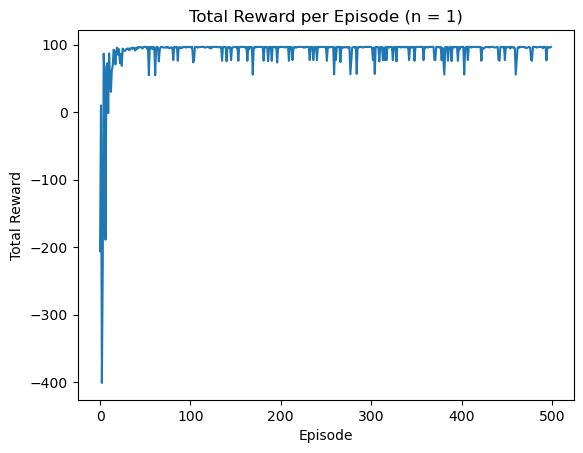

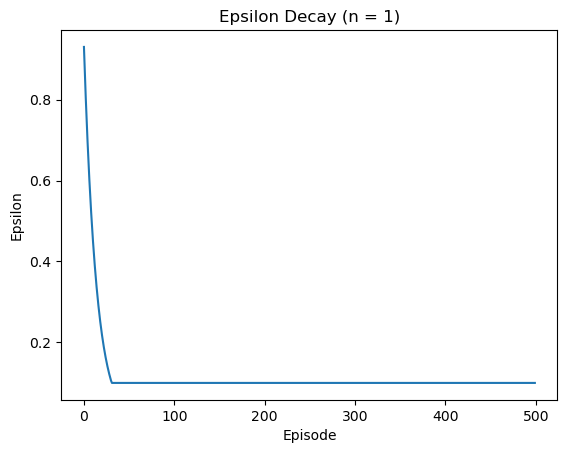

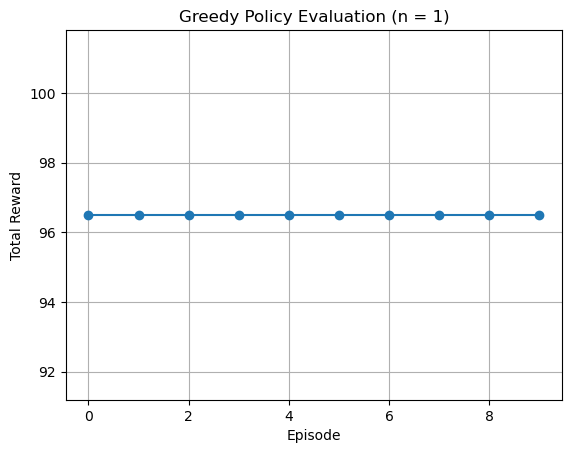


Evaluating for n = 2
Initial Q_A: [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Trained Q_A: [[-4.69764639e+00 -8.12645795e-01 -1.25410606e+01 -1.49381841e+00]
 [ 2.88067816e+00 -6.86719804e-01 -2.35659344e+00 -1.64095627e+00]
 [-2.21117731e+00 -3.66288479e-01  2.88488861e+01  3.10423659e+00]
 [-1.80594329e+00 -9.35050028e-01 -8.69250497e+00 -1.21357407e+00]
 [-1.49976382e+00 -1.25181635e+00 -3.01318408e+00 -3.41551007e+00]
 [-1.69644181e+00 -1.68399751e+00 -1.91147344e+00 -6.31606851e+00]
 [ 5.98111812e-01  1.41265729e+01  2.18731321e+01 -9.50409985e+00]
 [-1.80372835e+00 -7.30158873e+00 -2.57165634e+00 -3.91771179e+00]
 [-2.06621098e+00 -1.68150397e+00 -1.484

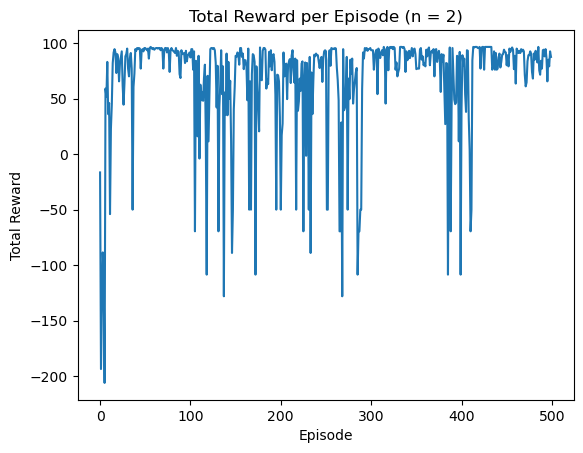

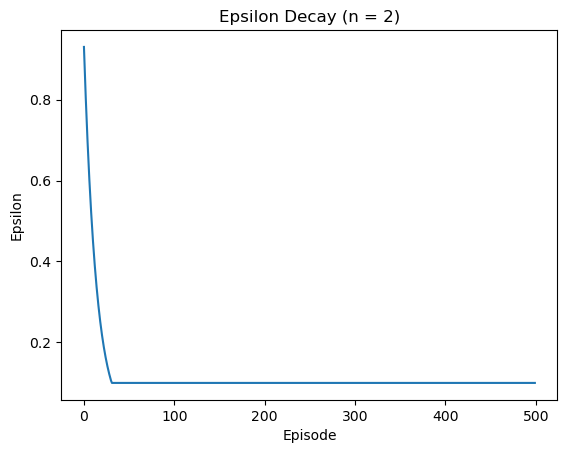

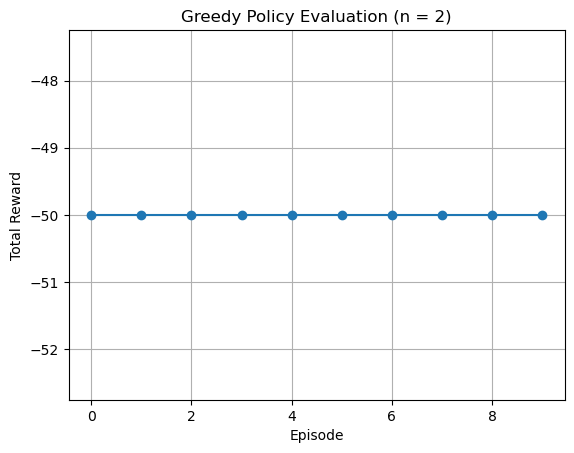


Evaluating for n = 3
Initial Q_A: [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Trained Q_A: [[ -3.4108915   -2.47243042 -17.45557362  -3.76737823]
 [ -4.85215436  -2.77262948   4.16050884  -4.12065288]
 [ -3.62756872  -2.95986659  -3.41847032  -3.14842138]
 [ -4.86310122  -6.57705016 -14.12663254  -4.83101599]
 [ -4.05431618  -2.95741307  -3.30660751  -4.04082241]
 [ -3.78632254  -2.61980393  -0.83884685  -7.408383  ]
 [ -4.23325601  -3.87227195   0.14570054 -15.79681625]
 [ -4.13554303 -14.95613004   1.87796893  -1.30268588]
 [ -3.3653273   -0.92477152  -0.134105    -1.55697023]
 [ -2.78710406  -3.01369917  15.42855927  -7.49904288]
 [-10.19353002  -3.6275674

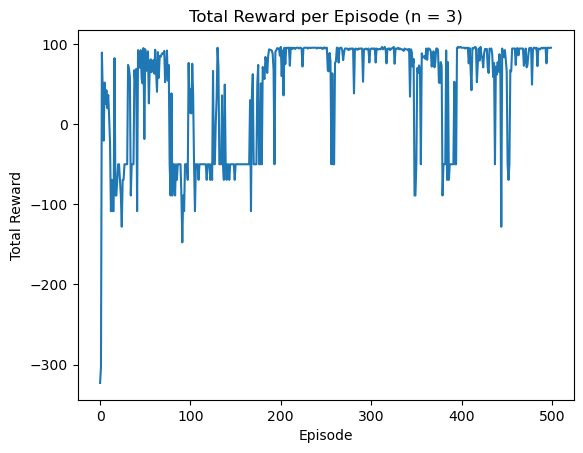

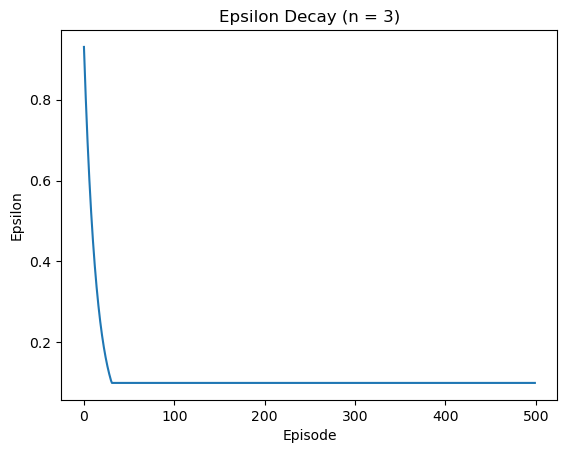

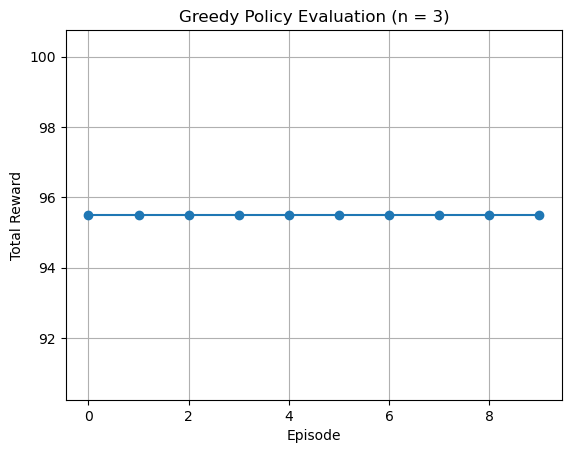


Evaluating for n = 4
Initial Q_A: [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Trained Q_A: [[-5.39449505e+00  5.47157825e+00 -1.06383816e+01 -3.12529937e+00]
 [-1.00348645e+00 -8.61786311e-01 -3.43112601e+00 -2.88490051e+00]
 [-2.98605845e+00 -3.47408635e+00  3.91643870e+00 -5.93887921e+00]
 [-6.29786450e+00 -6.96821158e+00 -5.79964742e+00 -2.31047307e+00]
 [-3.93383374e+00 -3.90589504e+00 -4.86522570e+00 -6.63278522e+00]
 [-1.26218576e-02 -2.38994281e+00 -2.31742146e+00 -6.90039425e+00]
 [-8.28023045e-02 -3.95139331e+00  1.72886148e+01 -1.30096563e+01]
 [-2.47515891e+00 -1.63463278e+01 -2.72333480e+00 -2.47890672e+00]
 [-2.42925182e+00 -3.87038885e+00  2.040

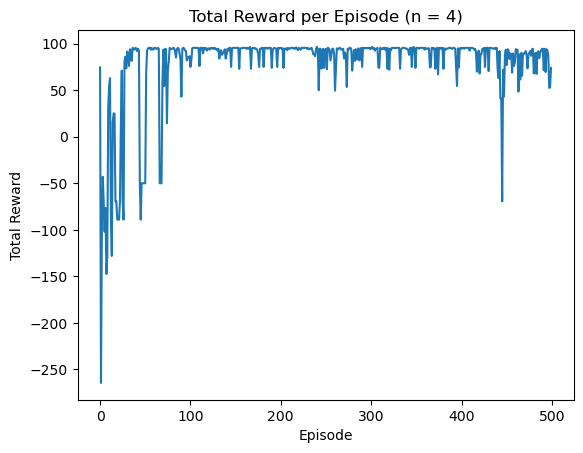

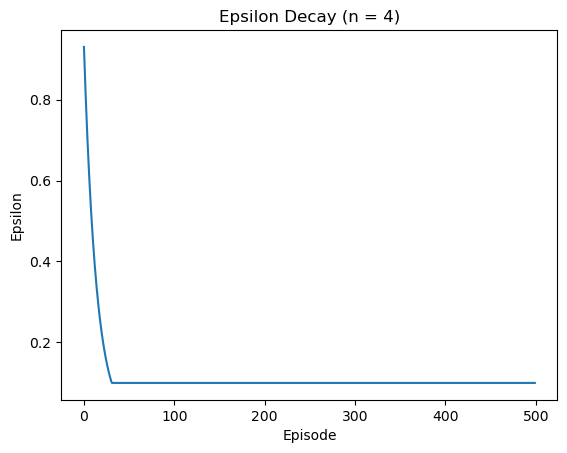

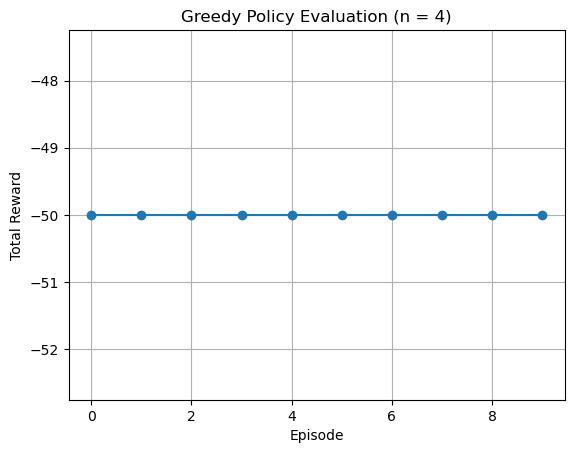


Evaluating for n = 5
Initial Q_A: [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Trained Q_A: [[-4.67762594e+00  1.27073114e+01 -1.95542291e+01 -7.01437963e+00]
 [-3.20504134e+00 -9.14888931e-01 -4.48954835e+00 -3.96533537e+00]
 [-2.17452947e+00 -1.93675818e+00  1.97951294e+00 -2.33345768e+00]
 [-4.77851580e+00 -4.02697913e+00 -5.60332993e+00 -2.65289489e+00]
 [-2.79240772e+00 -3.25644374e+00 -3.80148219e+00 -2.79264070e+00]
 [-2.18298498e+00 -4.82628736e+00 -1.61517920e+00 -7.32907684e+00]
 [-2.52892466e+00 -4.57106433e-01 -3.05727632e+00 -1.41277388e+01]
 [-3.99918471e+00 -1.04660380e+01 -2.42482520e+00 -2.68769376e+00]
 [-8.14084689e-01 -3.10083712e+00 -3.050

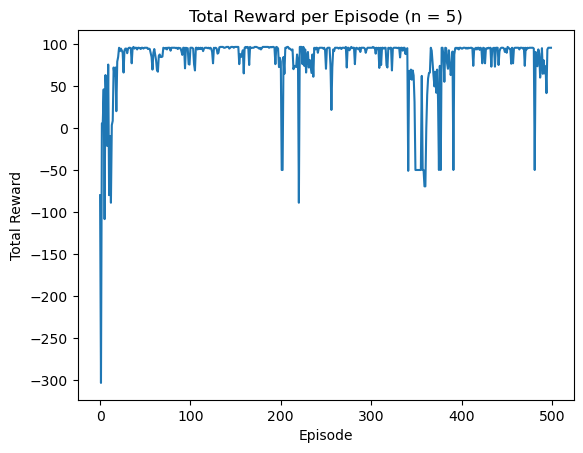

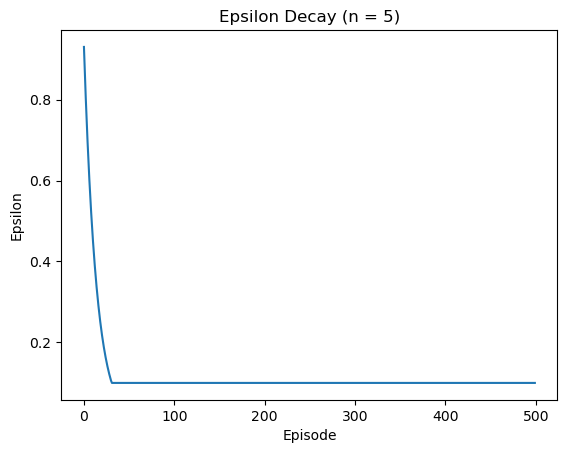

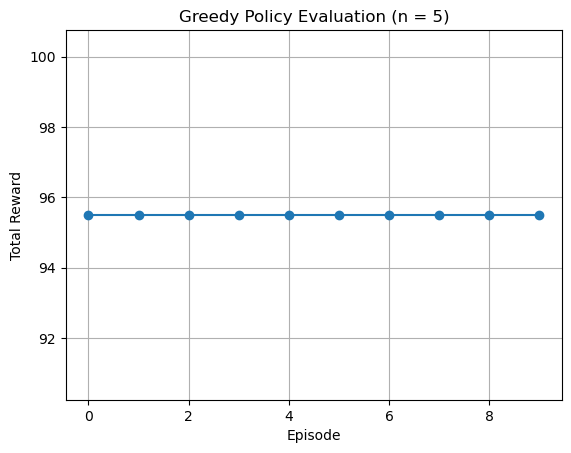

In [18]:
# Manual evaluation for n = 1 to 5
for n in range(1, 6):
    print(f"\nEvaluating for n = {n}")

    Q_A, Q_B, rewards_per_episode, epsilon_value = n_step_double_q_learning(
        env,
        episodes,
        alpha,
        best_params["gamma"],
        epsilon,
        best_params["epsilon_decay"],
        minimum_epsilon,
        maximum_timestep,
        n,
    )

    print("Initial Q_A:", np.zeros_like(Q_A))
    print("Trained Q_A:", Q_A)
    print("Initial Q_B:", np.zeros_like(Q_B))
    print("Trained Q_B:", Q_B)

    plt.plot(rewards_per_episode)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(f"Total Reward per Episode (n = {n})")
    plt.show()

    plt.plot(epsilon_value)
    plt.xlabel("Episode")
    plt.ylabel("Epsilon")
    plt.title(f"Epsilon Decay (n = {n})")
    plt.show()

    greedy_rewards = evaluate_greedy_policy(env, Q_A, Q_B)
    plt.plot(greedy_rewards, marker="o")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(f"Greedy Policy Evaluation (n = {n})")
    plt.grid()
    plt.show()
